# Closed Orbit perturbation

Let's consider a sudden kick $\Delta P_x = \Delta p_x/p_0$ acting at a position $s_0$ of a beamline. This will change the closed orbit, which is assumed to be initially following the reference trajectory ($x(s) = 0$). To satisfy the periodic condition of the closed orbit, one can show (A. Wolski, Chap. 6) that the closed-orbit-particle must have a non-zero action:
$$\begin{aligned}J_{x} &= \frac{\beta_{x}(s_0)\Delta P_x^2}{8\sin^2(\pi Q_x)}\\
\phi_x(s_0) &= -\pi Q_x\end{aligned}$$

And hence, with regard to the original reference trajectory, the closed orbit now follows:
$$x_\text{co}(s) = \sqrt{2\beta_x(s)J_x}\cos(|\mu_x(s_0,s)|-\pi Q_x) = \sqrt{\frac{\beta_x(s)\beta_x(s_0)}{4\sin^2(\pi Q_x)}} \Delta P_x \cos(|\mu_x(s_0,s)|-\pi Q_x)$$

In the case of a double wire configuration, the only dipolar kick comes from a misalignment of the 5th axis. One can show that:
$$\Delta P_x = -K_{N_0} = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2\cos(\phi_w)}{r_w}\right] = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2 x_w}{x_w^2 + y_w^2}\right]$$

And if the wires are installed in the horizontal plane:
$$\Delta P_y = K_{S_0} = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2\sin(\phi_w)}{r_w}\right] = \frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{2 y_w}{x_w^2 + y_w^2}\right]$$

Finally, to facilitate the analysis, one can look at $x_\text{co}(s)/\sqrt{\beta_x(s)}$


### Python implementation

In [1]:
import numpy as np
import Backend.Constants as cst

#=========================================
# Fitting function
#=========================================
def get_x_co(mux_s,betx_s,I,xw,yw,Qx,mu0 = 0,E = 450e9,L=1):
    # Confirming that mu and bet were given as vectors
    assert(np.shape(mux_s)==np.shape(betx_s))
    
    # Constants calculations
    Brho   = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    kick_0 = cst.mu0*(I*L)/(Brho*2*np.pi)
    kick   = kick_0*(2*xw/(xw**2+yw**2))
    
    # Finding beta at location of kick
    bet0 = betx_s[np.argmin(np.abs(mux_s-mu0))] 
    Amp  = np.sqrt(betx_s*bet0/(4*np.sin(np.pi*Qx)**2)) * kick
    
    return Amp*np.cos(2*np.pi*(np.abs(mux_s-mu0)) - np.pi*Qx)


def get_y_co(muy_s,bety_s,I,xw,yw,Qy,mu0 = 0,E = 450e9,L=1):
    # Confirming that mu and bet were given as vectors
    assert(np.shape(muy_s)==np.shape(bety_s))
    
    # Constants calculations
    Brho   = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    kick_0 = cst.mu0*(I*L)/(Brho*2*np.pi)
    kick   = kick_0*(2*yw/(xw**2+yw**2))
    
    # Finding beta at location of kick
    bet0 = bety_s[np.argmin(np.abs(muy_s-mu0))] 
    Amp  = np.sqrt(bety_s*bet0/(4*np.sin(np.pi*Qy)**2)) * kick
    
    return Amp*np.cos(2*np.pi*(np.abs(muy_s-mu0)) - np.pi*Qy)
#==========================================



## Reference exemple

In [ ]:
#%matplotlib widget

In [48]:
%matplotlib inline

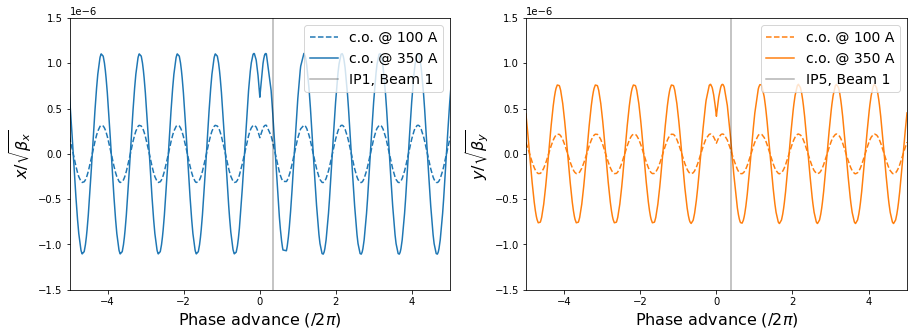

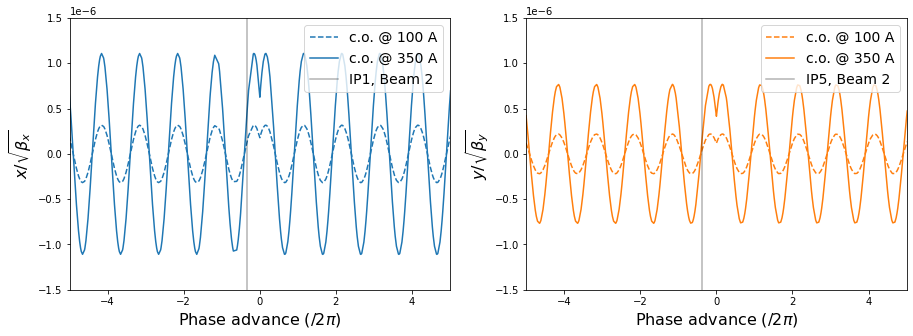

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx
import twissExtractor



# Importing twiss
#=====================

twiss = twissExtractor.fromOptics('opticsfile.1')


# Setting reasonable parameters
gap    = 15e-3
offset = 0.5e-3

# Looping for both beams and both IPs
for beam in ['B1','B2']:
    
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    
    
    for IP,ax in zip(['ip1','ip5'],axes):
        for I_w,ls in zip([100,350],['--','-']):
            _wires = [name for name in twiss[beam].index if ('bbcw' in name)&((f'{IP[-1]}.u' in name)|(f'{IP[-1]}.d' in name))]

            if IP.lower() == 'ip1':
                CO    = get_x_co(mux_s = twiss[beam]['mux'],
                                 betx_s= twiss[beam]['betx'],
                                 I     = I_w,
                                 xw    = offset,
                                 yw    = gap+3e-3,
                                 Qx    = twiss[beam]['mux'][-1],
                                 mu0   = twiss[beam].loc[_wires,'mux'].mean(),
                                 E = 450e9,L=1)
                mu_CO   = twiss[beam]['mux'].to_numpy() - twiss[beam].loc[_wires,'mux'].mean()
                norm_CO = CO/np.sqrt(twiss[beam]['betx'])
                IP_loc  = twiss[beam].loc[IP.lower(),'mux'] - twiss[beam].loc[_wires,'mux'].mean()

                color='C0'
                label=r'$x/\sqrt{\beta_x}$'

            if IP.lower() == 'ip5':
                CO    = get_y_co(muy_s = twiss[beam]['muy'],
                                 bety_s= twiss[beam]['bety'],
                                 I     = I_w,
                                 xw    = gap+3e-3,
                                 yw    = offset,
                                 Qy    = twiss[beam]['muy'][-1],
                                 mu0   = twiss[beam].loc[_wires,'muy'].mean(),
                                 E = 450e9,L=1)
                mu_CO   = twiss[beam]['muy'].to_numpy() - twiss[beam].loc[_wires,'muy'].mean()
                norm_CO = CO/np.sqrt(twiss[beam]['bety'])
                IP_loc  = twiss[beam].loc[IP.lower(),'muy'] - twiss[beam].loc[_wires,'muy'].mean()

                color='C1'
                label=r'$y/\sqrt{\beta_y}$'

            # Plotting
            plt.sca(ax)
            plt.plot(mu_CO,norm_CO,ls,color=color,label=f'c.o. @ {I_w} A')
            

        plt.axvline(IP_loc,color='k',alpha=0.3,label=IP.upper() + f', Beam {beam[-1]}')
        plt.ylabel(label,fontsize=16)
        plt.xlabel(r'Phase advance ($/2\pi$)',fontsize=16)
        plt.legend(loc='upper right',fontsize=14)
        plt.xlim([-5,5])
        plt.ylim([-1.5e-6,1.5e-6])


In [45]:

for i in range(30):

    mu_vec   = np.linspace(0.5,twiss[beam]['mux'][-1],i+100)
    cos_test = 5*np.cos(2*np.pi*mu_vec)
    signal = cos_test+np.random.normal(0,0.05*5,len(cos_test))

    #plt.figure()
    #plt.plot(mu_vec,signal)
    #plt.xlim([20,30])

    amp1 = (np.max(signal)-np.min(signal))/2
    amp2 = np.std(signal)*np.sqrt(2)
    print(40*'-')
    print(f'Max-min yields : {amp1:.15f}, Err: {np.abs(amp1-5)/5*100:.3}%')
    print(f'RMS yields     : {amp2:.15f}, Err: {np.abs(amp2-5)/5*100:.3}%')

----------------------------------------
Max-min yields : 5.411674710707629, Err: 8.23%
RMS yields     : 5.037502751112660, Err: 0.75%
----------------------------------------
Max-min yields : 5.287096035151783, Err: 5.74%
RMS yields     : 5.038909665061195, Err: 0.778%
----------------------------------------
Max-min yields : 5.297131934947902, Err: 5.94%
RMS yields     : 5.057963111025694, Err: 1.16%
----------------------------------------
Max-min yields : 5.330243248994318, Err: 6.6%
RMS yields     : 5.028189206263554, Err: 0.564%
----------------------------------------
Max-min yields : 5.019283576168103, Err: 0.386%
RMS yields     : 4.966858767591703, Err: 0.663%
----------------------------------------
Max-min yields : 5.444088089160992, Err: 8.88%
RMS yields     : 5.023723049401243, Err: 0.474%
----------------------------------------
Max-min yields : 5.570027999606721, Err: 11.4%
RMS yields     : 5.014490959780852, Err: 0.29%
----------------------------------------
Max-min yi